In [2]:
import os
import shutil
from PIL import Image
import sys
import uuid
from tqdm import tqdm
import numpy as np

sys.path.append('../src')

from utils.preprocess import (
    process_cloud_data, 
    visualize_rgb_and_mask, 
    create_file_pairs,
    identify_low_information_images,
    load_and_normalize_band,
    combine_rgb,
    load_and_process_mask,
    visualize_and_manage_images_masks,
    is_band_all_zeros,
    visualizar_rgb_normalizacao
)

## Listar os arquivos

Definir os Diretórios das Bandas e Máscaras

In [2]:
# Diretórios das bandas de treinamento 95-Cloud
train_red_dir_95 = '../data/raw/95-cloud_training_only_additional_to38-cloud/train_red_additional_to38cloud'
train_green_dir_95 = '../data/raw/95-cloud_training_only_additional_to38-cloud/train_green_additional_to38cloud'
train_blue_dir_95 = '../data/raw/95-cloud_training_only_additional_to38-cloud/train_blue_additional_to38cloud'
train_gt_dir_95 = '../data/raw/95-cloud_training_only_additional_to38-cloud/train_gt_additional_to38cloud'

# Diretórios das bandas de treinamento 38-Cloud
train_red_dir_38 = '../data/raw/38-Cloud_training/train_red'
train_green_dir_38 = '../data/raw/38-Cloud_training/train_green'
train_blue_dir_38 = '../data/raw/38-Cloud_training/train_blue'
train_gt_dir_38 = '../data/raw/38-Cloud_training/train_gt'

Listar os Arquivos Disponíveis

In [ ]:
# Listar arquivos de treinamento 95-Cloud
red_files_95 = sorted(os.listdir(train_red_dir_95))
green_files_95 = sorted(os.listdir(train_green_dir_95))
blue_files_95 = sorted(os.listdir(train_blue_dir_95))
mask_files_95 = sorted(os.listdir(train_gt_dir_95))

print(f'95-Cloud - Número de arquivos de banda vermelha: {len(red_files_95)}')
print(f'95-Cloud - Número de arquivos de banda verde: {len(green_files_95)}')
print(f'95-Cloud - Número de arquivos de banda azul: {len(blue_files_95)}')
print(f'95-Cloud - Número de máscaras: {len(mask_files_95)}')

In [ ]:
# Listar arquivos de treinamento 38-Cloud
red_files_38 = sorted(os.listdir(train_red_dir_38))
green_files_38 = sorted(os.listdir(train_green_dir_38))
blue_files_38 = sorted(os.listdir(train_blue_dir_38))
mask_files_38 = sorted(os.listdir(train_gt_dir_38))

print(f'38-Cloud - Número de arquivos de banda vermelha: {len(red_files_38)}')
print(f'38-Cloud - Número de arquivos de banda verde: {len(green_files_38)}')
print(f'38-Cloud - Número de arquivos de banda azul: {len(blue_files_38)}')
print(f'38-Cloud - Número de máscaras: {len(mask_files_38)}')

In [5]:
def get_base_name(filename):
    base_name = os.path.splitext(filename)[0]
    prefixes = ['red_', 'green_', 'blue_', 'gt_']
    for prefix in prefixes:
        if base_name.startswith(prefix):
            base_name = base_name[len(prefix):]
            break
    return base_name

In [ ]:
# Para 95-Cloud
red_files_dict_95 = {get_base_name(f): f for f in red_files_95}
green_files_dict_95 = {get_base_name(f): f for f in green_files_95}
blue_files_dict_95 = {get_base_name(f): f for f in blue_files_95}
mask_files_dict_95 = {get_base_name(f): f for f in mask_files_95}

# Encontrar os nomes base comuns para 95-Cloud
common_base_names_95 = set(red_files_dict_95.keys()) & set(green_files_dict_95.keys()) & set(blue_files_dict_95.keys()) & set(mask_files_dict_95.keys())

print(f'95-Cloud - Número de arquivos comuns: {len(common_base_names_95)}')

# Criar uma lista de pares de arquivos correspondentes para 95-Cloud
file_pairs_95 = []
for base_name in sorted(common_base_names_95):
    r_file = red_files_dict_95[base_name]
    g_file = green_files_dict_95[base_name]
    b_file = blue_files_dict_95[base_name]
    m_file = mask_files_dict_95[base_name]
    file_pairs_95.append((base_name, r_file, g_file, b_file, m_file))

In [ ]:
# Para 38-Cloud
red_files_dict_38 = {get_base_name(f): f for f in red_files_38}
green_files_dict_38 = {get_base_name(f): f for f in green_files_38}
blue_files_dict_38 = {get_base_name(f): f for f in blue_files_38}
mask_files_dict_38 = {get_base_name(f): f for f in mask_files_38}

# Encontrar os nomes base comuns para 38-Cloud
common_base_names_38 = set(red_files_dict_38.keys()) & set(green_files_dict_38.keys()) & set(blue_files_dict_38.keys()) & set(mask_files_dict_38.keys())

print(f'38-Cloud - Número de arquivos comuns: {len(common_base_names_38)}')

# Criar uma lista de pares de arquivos correspondentes para 38-Cloud
file_pairs_38 = []
for base_name in sorted(common_base_names_38):
    r_file = red_files_dict_38[base_name]
    g_file = green_files_dict_38[base_name]
    b_file = blue_files_dict_38[base_name]
    m_file = mask_files_dict_38[base_name]
    file_pairs_38.append((base_name, r_file, g_file, b_file, m_file))

## Algumas imagens não possuem informação, portanto vamos removê-las

In [8]:
# Diretórios para 95-Cloud - agora separando por bandas
excluded_images_dir_95 = '../data/excluded/95-cloud/images/'
excluded_masks_dir_95 = '../data/excluded/95-cloud/masks/'

processed_red_dir_95 = '../data/processed/95-cloud/images/train/red'
processed_green_dir_95 = '../data/processed/95-cloud/images/train/green'
processed_blue_dir_95 = '../data/processed/95-cloud/images/train/blue'
processed_masks_dir_95 = '../data/processed/95-cloud/masks/train/'

# Diretórios para 38-Cloud - agora separando por bandas
excluded_images_dir_38 = '../data/excluded/38-cloud/images/'
excluded_masks_dir_38 = '../data/excluded/38-cloud/masks/'

processed_red_dir_38 = '../data/processed/38-cloud/images/train/red'
processed_green_dir_38 = '../data/processed/38-cloud/images/train/green'
processed_blue_dir_38 = '../data/processed/38-cloud/images/train/blue'
processed_masks_dir_38 = '../data/processed/38-cloud/masks/train/'

# Criar os diretórios se não existirem
os.makedirs(excluded_images_dir_95, exist_ok=True)
os.makedirs(excluded_masks_dir_95, exist_ok=True)
os.makedirs(processed_red_dir_95, exist_ok=True)
os.makedirs(processed_green_dir_95, exist_ok=True)
os.makedirs(processed_blue_dir_95, exist_ok=True)
os.makedirs(processed_masks_dir_95, exist_ok=True)

os.makedirs(excluded_images_dir_38, exist_ok=True)
os.makedirs(excluded_masks_dir_38, exist_ok=True)
os.makedirs(processed_red_dir_38, exist_ok=True)
os.makedirs(processed_green_dir_38, exist_ok=True)
os.makedirs(processed_blue_dir_38, exist_ok=True)
os.makedirs(processed_masks_dir_38, exist_ok=True)


In [ ]:
# Processar o conjunto 95-Cloud e capturar excluídos
excluded_files_95 = process_cloud_data(
    file_pairs=file_pairs_95, 
    train_red_dir=train_red_dir_95, 
    train_green_dir=train_green_dir_95, 
    train_blue_dir=train_blue_dir_95, 
    train_gt_dir=train_gt_dir_95, 
    processed_red_dir=processed_red_dir_95,
    processed_green_dir=processed_green_dir_95,
    processed_blue_dir=processed_blue_dir_95,
    processed_masks_dir=processed_masks_dir_95, 
    excluded_images_dir=excluded_images_dir_95, 
    excluded_masks_dir=excluded_masks_dir_95, 
    cloud_name='95-Cloud'
)

# Processar o conjunto 38-Cloud e capturar excluídos
excluded_files_38 = process_cloud_data(
    file_pairs=file_pairs_38, 
    train_red_dir=train_red_dir_38, 
    train_green_dir=train_green_dir_38, 
    train_blue_dir=train_blue_dir_38, 
    train_gt_dir=train_gt_dir_38, 
    processed_red_dir=processed_red_dir_38,
    processed_green_dir=processed_green_dir_38,
    processed_blue_dir=processed_blue_dir_38,
    processed_masks_dir=processed_masks_dir_38, 
    excluded_images_dir=excluded_images_dir_38, 
    excluded_masks_dir=excluded_masks_dir_38, 
    cloud_name='38-Cloud'
)


In [11]:
# Converter as listas de excluídos para file_pairs_excluded
file_pairs_excluded_95 = excluded_files_95
file_pairs_excluded_38 = excluded_files_38

## Imagens excluídas 95-Cloud

In [ ]:
# Visualizar imagens excluídas para 95-Cloud
if file_pairs_excluded_95:
    visualize_rgb_and_mask(
        file_pairs_excluded_95, 
        train_red_dir=excluded_images_dir_95, 
        train_green_dir=excluded_images_dir_95, 
        train_blue_dir=excluded_images_dir_95, 
        train_gt_dir=excluded_masks_dir_95, 
        images_per_figure=5
    )
else:
    print("Nenhuma imagem excluída para 95-Cloud para visualizar.")

## Imagens excluídas 38-Cloud

In [ ]:
# Visualizar imagens excluídas para 95-Cloud
if file_pairs_excluded_38:
    visualize_rgb_and_mask(
        file_pairs_excluded_38, 
        train_red_dir=excluded_images_dir_38, 
        train_green_dir=excluded_images_dir_38, 
        train_blue_dir=excluded_images_dir_38, 
        train_gt_dir=excluded_masks_dir_38, 
        images_per_figure=5
    )
else:
    print("Nenhuma imagem excluída para 38-Cloud para visualizar.")

## Imagens 38-Cloud

In [ ]:
# Criar file_pairs para 38-Cloud a partir dos diretórios já processados
file_pairs_processed_38 = create_file_pairs(
    processed_red_dir=processed_red_dir_38, 
    processed_green_dir=processed_green_dir_38, 
    processed_blue_dir=processed_blue_dir_38,   
    processed_mask_dir=processed_masks_dir_38
)

In [ ]:
# Verificar se existem file_pairs antes de visualizar
if file_pairs_processed_38:
    print("Visualizando imagens processadas para 38-Cloud...")
    visualize_rgb_and_mask(
        file_pairs=file_pairs_processed_38, 
        train_red_dir=processed_red_dir_38, 
        train_green_dir=processed_green_dir_38, 
        train_blue_dir=processed_blue_dir_38, 
        train_gt_dir=processed_masks_dir_38, 
        images_per_figure=5
    )
else:
    print("Nenhuma imagem processada para 38-Cloud para visualizar.")

## Imagens 95-Cloud

In [ ]:
# Criar file_pairs para 95-Cloud a partir dos diretórios já processados
file_pairs_processed_95 = create_file_pairs(
    processed_red_dir=processed_red_dir_95, 
    processed_green_dir=processed_green_dir_95, 
    processed_blue_dir=processed_blue_dir_95,   
    processed_mask_dir=processed_masks_dir_95
)

In [ ]:
# Verificar se existem file_pairs antes de visualizar
if file_pairs_processed_95:
    print("Visualizando imagens processadas para 95-Cloud...")
    visualize_rgb_and_mask(
        file_pairs=file_pairs_processed_95, 
        train_red_dir=processed_red_dir_95, 
        train_green_dir=processed_green_dir_95, 
        train_blue_dir=processed_blue_dir_95, 
        train_gt_dir=processed_masks_dir_95, 
        images_per_figure=5
    )
else:
    print("Nenhuma imagem processada para 95-Cloud para visualizar.")

## Excluindo imagens muito pequenas

### 95-Cloud

In [ ]:
# Definir o limiar de percentagem de pixels não nulos
threshold_percentage = 10  # Ajuste conforme necessário

# --- Para 95-Cloud ---
# Diretórios dos dados processados para 95-Cloud
processed_red_dir_95 = '../data/processed/95-cloud/images/train/red'
processed_green_dir_95 = '../data/processed/95-cloud/images/train/green'
processed_blue_dir_95 = '../data/processed/95-cloud/images/train/blue'
processed_masks_dir_95 = '../data/processed/95-cloud/masks/train/'

# Diretórios para onde as imagens serão movidas após exclusão para 95-Cloud
excluded_from_processed_images_dir_95 = '../data/processed/95-cloud/images/excluded_low_info'
excluded_from_processed_masks_dir_95 = '../data/processed/95-cloud/masks/excluded_low_info'

# Criar os diretórios de exclusão se não existirem
os.makedirs(excluded_from_processed_images_dir_95, exist_ok=True)
os.makedirs(excluded_from_processed_masks_dir_95, exist_ok=True)

# Identificar imagens com pouca informação para 95-Cloud
low_info_file_pairs_95 = identify_low_information_images(
        processed_red_dir=processed_red_dir_95,
        processed_green_dir=processed_green_dir_95,
        processed_blue_dir=processed_blue_dir_95,
        processed_masks_dir=processed_masks_dir_95,
        threshold_percentage=threshold_percentage
    )

# Plotar as imagens e máscaras ruins antes de excluir para 95-Cloud
if low_info_file_pairs_95:
    visualize_rgb_and_mask(
            low_info_file_pairs_95, 
            train_red_dir=processed_red_dir_95,
            train_green_dir=processed_green_dir_95,
            train_blue_dir=processed_blue_dir_95,
            train_gt_dir=processed_masks_dir_95,
            images_per_figure=5
        )
else:
    print("Nenhuma imagem com pouca informação para visualizar/excluir no 95-Cloud.")

In [ ]:
# Excluir as imagens ruins para 95-Cloud
if low_info_file_pairs_95:
    for base_name, r_file, g_file, b_file, m_file in low_info_file_pairs_95:
        r_path = os.path.join(processed_red_dir_95, r_file)
        g_path = os.path.join(processed_green_dir_95, g_file)
        b_path = os.path.join(processed_blue_dir_95, b_file)
        m_path = os.path.join(processed_masks_dir_95, m_file)

        # Mover as bandas
        if os.path.exists(r_path):
            shutil.move(r_path, os.path.join(excluded_from_processed_images_dir_95, r_file))
        if os.path.exists(g_path):
            shutil.move(g_path, os.path.join(excluded_from_processed_images_dir_95, g_file))
        if os.path.exists(b_path):
            shutil.move(b_path, os.path.join(excluded_from_processed_images_dir_95, b_file))
        # Mover a máscara
        if os.path.exists(m_path):
            shutil.move(m_path, os.path.join(excluded_from_processed_masks_dir_95, m_file))
    
    print("Imagens com pouca informação movidas para a pasta de excluídos no 95-Cloud.")
else:
    print("Nenhuma imagem com pouca informação para excluir no 95-Cloud.")

### 38-Clound

In [ ]:
# Definir o limiar de percentagem de pixels não nulos
threshold_percentage = 10  # Ajuste conforme necessário

# --- Para 38-Cloud ---
# Diretórios dos dados processados para 38-Cloud
processed_red_dir_38 = '../data/processed/38-cloud/images/train/red'
processed_green_dir_38 = '../data/processed/38-cloud/images/train/green'
processed_blue_dir_38 = '../data/processed/38-cloud/images/train/blue'
processed_masks_dir_38 = '../data/processed/38-cloud/masks/train/'

# Diretórios para onde as imagens serão movidas após exclusão para 38-Cloud
excluded_from_processed_images_dir_38 = '../data/processed/38-cloud/images/excluded_low_info'
excluded_from_processed_masks_dir_38 = '../data/processed/38-cloud/masks/excluded_low_info'

# Criar os diretórios de exclusão se não existirem
os.makedirs(excluded_from_processed_images_dir_38, exist_ok=True)
os.makedirs(excluded_from_processed_masks_dir_38, exist_ok=True)

# Identificar imagens com pouca informação para 38-Cloud
low_info_file_pairs_38 = identify_low_information_images(
        processed_red_dir=processed_red_dir_38,
        processed_green_dir=processed_green_dir_38,
        processed_blue_dir=processed_blue_dir_38,
        processed_masks_dir=processed_masks_dir_38,
        threshold_percentage=threshold_percentage
    )

# Plotar as imagens e máscaras ruins antes de excluir para 38-Cloud
if low_info_file_pairs_38:
    visualize_rgb_and_mask(
            low_info_file_pairs_38, 
            train_red_dir=processed_red_dir_38,
            train_green_dir=processed_green_dir_38,
            train_blue_dir=processed_blue_dir_38,
            train_gt_dir=processed_masks_dir_38,
            images_per_figure=5
        )
else:
    print("Nenhuma imagem com pouca informação para visualizar/excluir no 38-Cloud.")

In [ ]:
# Excluir as imagens ruins para 38-Cloud
if low_info_file_pairs_38:
    for base_name, r_file, g_file, b_file, m_file in low_info_file_pairs_38:
        r_path = os.path.join(processed_red_dir_38, r_file)
        g_path = os.path.join(processed_green_dir_38, g_file)
        b_path = os.path.join(processed_blue_dir_38, b_file)
        m_path = os.path.join(processed_masks_dir_38, m_file)

        # Mover as bandas
        if os.path.exists(r_path):
            shutil.move(r_path, os.path.join(excluded_from_processed_images_dir_38, r_file))
        if os.path.exists(g_path):
            shutil.move(g_path, os.path.join(excluded_from_processed_images_dir_38, g_file))
        if os.path.exists(b_path):
            shutil.move(b_path, os.path.join(excluded_from_processed_images_dir_38, b_file))
        # Mover a máscara
        if os.path.exists(m_path):
            shutil.move(m_path, os.path.join(excluded_from_processed_masks_dir_38, m_file))
    
    print("Imagens com pouca informação movidas para a pasta de excluídos no 38-Cloud.")
else:
    print("Nenhuma imagem com pouca informação para excluir no 38-Cloud.")

## Excluindo algumas imagens ruins

### 95-Cloud

In [43]:
# Lista de nomes base das imagens ruins
bad_base_names = [
                  ]  

# Diretórios dos dados processados 
processed_red_dir = '../data/processed/95-cloud/images/train/red'
processed_green_dir = '../data/processed/95-cloud/images/train/green'
processed_blue_dir = '../data/processed/95-cloud/images/train/blue'
processed_masks_dir = '../data/processed/95-cloud/masks/train/'

# Diretórios para onde as imagens serão movidas após exclusão
excluded_from_processed_images_dir = '../data/excluded/95-cloud/images'
excluded_from_processed_masks_dir = '../data/excluded/95-cloud/masks'

# Criar os diretórios de exclusão se não existirem
os.makedirs(excluded_from_processed_images_dir, exist_ok=True)
os.makedirs(excluded_from_processed_masks_dir, exist_ok=True)

def get_bad_file_pairs(bad_base_names, red_dir, green_dir, blue_dir, mask_dir, extension='.TIF'):
    """
    Cria file_pairs apenas para as imagens ruins, assumindo que os arquivos
    seguem o padrão red_base_name.ext, green_base_name.ext, etc.
    """
    file_pairs = []
    for base_name in bad_base_names:
        r_file = f'red_{base_name}{extension}'
        g_file = f'green_{base_name}{extension}'
        b_file = f'blue_{base_name}{extension}'
        m_file = f'gt_{base_name}{extension}'

        # Verifica a existência dos arquivos
        r_path = os.path.join(red_dir, r_file)
        g_path = os.path.join(green_dir, g_file)
        b_path = os.path.join(blue_dir, b_file)
        m_path = os.path.join(mask_dir, m_file)

        if os.path.exists(r_path) and os.path.exists(g_path) and os.path.exists(b_path) and os.path.exists(m_path):
            file_pairs.append((base_name, r_file, g_file, b_file, m_file))
        else:
            print(f"Arquivos da imagem {base_name} não encontrados, não será possível visualizar/excluir.")
    return file_pairs

# Cria os file_pairs das imagens ruins
bad_file_pairs = get_bad_file_pairs(
    bad_base_names, 
    processed_red_dir, 
    processed_green_dir, 
    processed_blue_dir, 
    processed_masks_dir,
    extension='.TIF'  
)

In [ ]:
# Plotar as imagens e máscaras ruins antes de excluir
if bad_file_pairs:
    visualize_rgb_and_mask(
        bad_file_pairs, 
        train_red_dir=processed_red_dir,
        train_green_dir=processed_green_dir,
        train_blue_dir=processed_blue_dir,
        train_gt_dir=processed_masks_dir,
        images_per_figure=5
    )
else:
    print("Nenhuma imagem para visualizar/excluir.")

In [ ]:
# Função para excluir (mover) as imagens ruins
def exclude_bad_images(file_pairs, red_dir, green_dir, blue_dir, mask_dir, 
                       excluded_images_dir, excluded_masks_dir):
    for base_name, r_file, g_file, b_file, m_file in file_pairs:
        r_path = os.path.join(red_dir, r_file)
        g_path = os.path.join(green_dir, g_file)
        b_path = os.path.join(blue_dir, b_file)
        m_path = os.path.join(mask_dir, m_file)

        # Mover as bandas
        if os.path.exists(r_path):
            shutil.move(r_path, os.path.join(excluded_images_dir, r_file))
        if os.path.exists(g_path):
            shutil.move(g_path, os.path.join(excluded_images_dir, g_file))
        if os.path.exists(b_path):
            shutil.move(b_path, os.path.join(excluded_images_dir, b_file))
        # Mover a máscara
        if os.path.exists(m_path):
            shutil.move(m_path, os.path.join(excluded_masks_dir, m_file))

# Excluir as imagens ruins
exclude_bad_images(
    bad_file_pairs, 
    processed_red_dir, 
    processed_green_dir, 
    processed_blue_dir, 
    processed_masks_dir, 
    excluded_from_processed_images_dir, 
    excluded_from_processed_masks_dir
)

print("Imagens ruins movidas para a pasta de excluídos.")

### 38-Cloud

In [60]:
# Lista de nomes base das imagens ruins
bad_base_names = ['patch_430_19_by_16_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_429_19_by_15_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_428_19_by_14_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_427_19_by_13_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_426_19_by_12_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_425_19_by_11_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_424_19_by_10_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_423_19_by_9_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_422_19_by_8_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_421_19_by_7_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_421_19_by_7_LC08_L1TP_059014_20160620_20170221_01_T1',
                  'patch_420_19_by_6_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_416_20_by_17_LC08_L1TP_032029_20160420_20170223_01_T1',
                  'patch_409_18_by_18_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_408_18_by_17_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_407_18_by_16_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_406_18_by_15_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_405_18_by_14_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_404_18_by_13_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_403_18_by_12_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_402_18_by_11_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_401_18_by_10_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_400_18_by_9_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_399_18_by_8_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_398_18_by_7_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_397_18_by_6_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_395_19_by_17_LC08_L1TP_032029_20160420_20170223_01_T1',
                  'patch_395_17_by_11_LC08_L1TP_011002_20160620_20170323_01_T1',
                  'patch_387_17_by_19_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_386_17_by_18_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_385_17_by_17_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_384_17_by_16_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_383_17_by_15_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_382_17_by_14_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_381_17_by_13_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_380_17_by_12_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_379_17_by_11_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_378_18_by_4_LC08_L1TP_063016_20160920_20170221_01_T1',
                  'patch_378_17_by_10_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_377_17_by_9_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_376_17_by_8_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_375_17_by_7_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_374_17_by_6_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_372_17_by_4_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_370_17_by_18_LC08_L1TP_066017_20160520_20170223_01_T1',
                  'patch_364_16_by_19_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_363_16_by_18_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_362_16_by_17_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_360_16_by_15_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_359_16_by_14_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_358_16_by_13_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_357_16_by_12_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_356_16_by_11_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_355_16_by_10_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_354_16_by_9_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_353_16_by_8_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_352_16_by_7_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_351_16_by_6_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_350_16_by_5_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_342_15_by_20_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_341_15_by_19_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_340_15_by_18_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_340_15_by_4_LC08_L1TP_011002_20160620_20170323_01_T1',
                  'patch_339_15_by_17_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_338_15_by_16_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_337_15_by_15_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_337_16_by_7_LC08_L1TP_063016_20160920_20170221_01_T1',
                  'patch_336_15_by_14_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_335_15_by_13_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_334_15_by_12_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_333_15_by_11_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_332_15_by_10_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_331_15_by_9_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_330_15_by_8_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_329_15_by_7_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_328_15_by_6_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_327_15_by_5_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_319_14_by_20_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_318_14_by_19_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_317_14_by_18_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_316_14_by_4_LC08_L1TP_011002_20160620_20170323_01_T1',
                  'patch_316_14_by_17_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_315_14_by_3_LC08_L1TP_011002_20160620_20170323_01_T1',
                  'patch_314_14_by_15_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_313_14_by_14_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_312_14_by_13_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_311_14_by_12_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_310_14_by_11_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_309_14_by_10_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_308_14_by_9_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_307_14_by_8_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_306_14_by_7_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_305_14_by_19_LC08_L1TP_066017_20160520_20170223_01_T1',
                  'patch_305_14_by_6_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_304_14_by_18_LC08_L1TP_066017_20160520_20170223_01_T1',
                  'patch_304_14_by_5_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_303_14_by_17_LC08_L1TP_066017_20160520_20170223_01_T1',
                  'patch_302_14_by_16_LC08_L1TP_066017_20160520_20170223_01_T1',
                  'patch_297_13_by_21_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_296_13_by_20_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_295_13_by_19_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_294_13_by_18_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_293_13_by_17_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_292_13_by_16_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_291_13_by_15_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_290_13_by_14_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_289_13_by_13_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_288_13_by_12_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_287_13_by_11_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_286_13_by_10_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_285_13_by_9_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_284_13_by_8_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_283_13_by_7_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_282_13_by_6_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_281_13_by_5_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_280_13_by_4_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_275_12_by_22_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_274_12_by_21_LC08_L1TP_059014_20160620_20170221_01_T1',
                  'patch_274_12_by_21_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_273_12_by_20_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_272_12_by_19_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_271_12_by_18_LC08_L1TP_044010_20160220_20170224_01_T1',                
                  'patch_270_12_by_17_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_269_12_by_16_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_268_12_by_15_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_267_12_by_14_LC08_L1TP_044010_20160220_20170224_01_T1',                 
                  'patch_266_12_by_13_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_265_12_by_12_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_264_12_by_11_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_263_12_by_10_LC08_L1TP_044010_20160220_20170224_01_T1', 
                  'patch_262_12_by_9_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_261_12_by_8_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_260_12_by_7_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_259_12_by_6_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_258_12_by_5_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_257_12_by_4_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_257_12_by_4_LC08_L1TP_059014_20160620_20170221_01_T1',
                  'patch_252_11_by_22_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_251_11_by_21_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_250_11_by_20_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_249_11_by_19_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_248_11_by_18_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_247_11_by_17_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_246_11_by_16_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_245_11_by_15_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_244_11_by_14_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_243_11_by_13_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_242_11_by_12_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_241_11_by_11_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_240_11_by_10_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_239_11_by_9_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_238_11_by_8_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_237_11_by_7_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_236_11_by_6_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_235_11_by_5_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_234_11_by_4_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_230_10_by_23_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_229_10_by_22_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_228_10_by_21_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_227_10_by_20_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_226_10_by_19_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_225_10_by_18_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_224_10_by_17_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_223_10_by_16_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_222_10_by_15_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_221_10_by_14_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_220_10_by_13_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_219_10_by_12_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_218_10_by_11_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_217_10_by_10_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_216_10_by_9_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_215_10_by_8_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_214_10_by_7_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_213_10_by_6_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_212_10_by_5_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_211_10_by_4_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_207_9_by_23_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_206_9_by_22_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_205_9_by_21_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_204_9_by_20_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_203_9_by_19_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_202_9_by_18_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_201_9_by_17_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_200_9_by_16_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_199_9_by_15_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_198_9_by_14_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_196_9_by_12_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_195_9_by_11_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_194_9_by_10_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_193_9_by_9_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_192_9_by_8_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_191_9_by_7_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_190_9_by_6_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_189_9_by_5_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_182_8_by_21_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_181_8_by_20_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_180_8_by_19_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_179_8_by_18_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_178_8_by_17_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_177_8_by_16_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_176_8_by_15_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_175_8_by_14_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_174_8_by_13_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_173_8_by_12_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_172_8_by_11_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_171_8_by_10_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_170_8_by_9_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_169_8_by_8_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_168_8_by_7_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_167_8_by_6_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_166_8_by_5_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_157_7_by_19_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_156_7_by_18_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_155_7_by_17_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_154_7_by_16_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_153_7_by_15_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_152_8_by_5_LC08_L1TP_011247_20160620_20170323_01_T1',
                  'patch_152_7_by_14_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_151_7_by_19_LC08_L1TP_066017_20160520_20170223_01_T1',
                  'patch_151_7_by_13_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_150_7_by_18_LC08_L1TP_066017_20160520_20170223_01_T1',
                  'patch_150_7_by_12_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_149_7_by_11_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_148_7_by_10_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_147_7_by_9_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_146_7_by_8_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_145_8_by_5_LC08_L1TP_002053_20160520_20170324_01_T1',
                  'patch_145_7_by_7_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_144_7_by_6_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_133_6_by_18_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_132_6_by_17_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_131_6_by_21_LC08_L1TP_063016_20160920_20170221_01_T1',
                  'patch_131_6_by_16_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_130_6_by_15_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_129_6_by_14_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_128_6_by_13_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_127_7_by_7_LC08_L1TP_002053_20160520_20170324_01_T1',
                  'patch_127_6_by_12_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_126_7_by_6_LC08_L1TP_002053_20160520_20170324_01_T1',
                  'patch_126_6_by_11_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_125_7_by_5_LC08_L1TP_002053_20160520_20170324_01_T1',
                  'patch_125_6_by_10_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_124_6_by_9_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_123_7_by_3_LC08_L1TP_002053_20160520_20170324_01_T1',
                  'patch_123_6_by_8_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_122_6_by_7_LC08_L1TP_044010_20160220_20170224_01_T1',
                  'patch_121_6_by_11_LC08_L1TP_063016_20160920_20170221_01_T1'
                  ]  

# Diretórios dos dados processados (ajuste conforme sua estrutura)
processed_red_dir = '../data/processed/38-cloud/images/train/red'
processed_green_dir = '../data/processed/38-cloud/images/train/green'
processed_blue_dir = '../data/processed/38-cloud/images/train/blue'
processed_masks_dir = '../data/processed/38-cloud/masks/train/'

# Diretórios para onde as imagens serão movidas após exclusão
excluded_from_processed_images_dir = '../data/processed/38-cloud/images/excluded'
excluded_from_processed_masks_dir = '../data/processed/38-cloud/masks/excluded'

# Criar os diretórios de exclusão se não existirem
os.makedirs(excluded_from_processed_images_dir, exist_ok=True)
os.makedirs(excluded_from_processed_masks_dir, exist_ok=True)


# Cria os file_pairs das imagens ruins
bad_file_pairs = get_bad_file_pairs(
    bad_base_names, 
    processed_red_dir, 
    processed_green_dir, 
    processed_blue_dir, 
    processed_masks_dir,
    extension='.TIF'  
)

In [ ]:
# Plotar as imagens e máscaras ruins antes de excluir
if bad_file_pairs:
    visualize_rgb_and_mask(
        bad_file_pairs, 
        train_red_dir=processed_red_dir,
        train_green_dir=processed_green_dir,
        train_blue_dir=processed_blue_dir,
        train_gt_dir=processed_masks_dir,
        images_per_figure=5
    )
else:
    print("Nenhuma imagem para visualizar/excluir.")

In [ ]:
# Excluir as imagens ruins
exclude_bad_images(
    bad_file_pairs, 
    processed_red_dir, 
    processed_green_dir, 
    processed_blue_dir, 
    processed_masks_dir, 
    excluded_from_processed_images_dir, 
    excluded_from_processed_masks_dir
)

print("Imagens ruins movidas para a pasta de excluídos.")

# Pré processamento

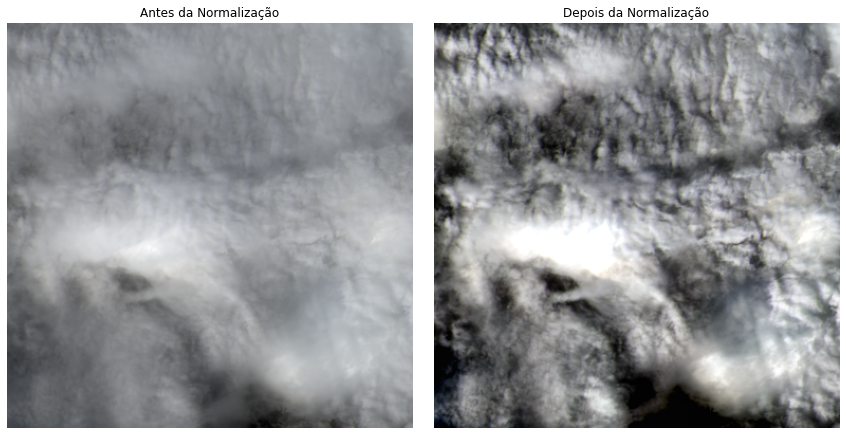

In [2]:
caminho_red = '../data/raw/38-Cloud_training/train_red/red_patch_278_14_by_5_LC08_L1TP_011247_20160620_20170323_01_T1.TIF'
caminho_green = '../data/raw/38-Cloud_training/train_green/green_patch_278_14_by_5_LC08_L1TP_011247_20160620_20170323_01_T1.TIF'
caminho_blue = '../data/raw/38-Cloud_training/train_blue/blue_patch_278_14_by_5_LC08_L1TP_011247_20160620_20170323_01_T1.TIF'

visualizar_rgb_normalizacao(caminho_red, caminho_green, caminho_blue)

# Salvando e preprocessando as imagens

In [78]:
# Diretórios de entrada - 95-cloud
processed_red_dir_95 = '../data/processed/95-cloud/images/train/red'
processed_green_dir_95 = '../data/processed/95-cloud/images/train/green'
processed_blue_dir_95 = '../data/processed/95-cloud/images/train/blue'
processed_masks_dir_95 = '../data/processed/95-cloud/masks/train/'

# Diretórios de entrada - 38-cloud
processed_red_dir_38 = '../data/processed/38-cloud/images/train/red'
processed_green_dir_38 = '../data/processed/38-cloud/images/train/green'
processed_blue_dir_38 = '../data/processed/38-cloud/images/train/blue'
processed_masks_dir_38 = '../data/processed/38-cloud/masks/train/'

# Diretórios de saída
output_images_dir = '../data/dados/images'
output_masks_dir = '../data/dados/masks'

os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_masks_dir, exist_ok=True)

In [ ]:
# Cria pares de arquivos para 95-cloud
file_pairs_95 = create_file_pairs(processed_red_dir_95, processed_green_dir_95, processed_blue_dir_95, processed_masks_dir_95)

# Cria pares de arquivos para 38-cloud
file_pairs_38 = create_file_pairs(processed_red_dir_38, processed_green_dir_38, processed_blue_dir_38, processed_masks_dir_38)

# Combina os pares de ambos datasets
all_file_pairs = [(processed_red_dir_95, processed_green_dir_95, processed_blue_dir_95, processed_masks_dir_95, fp) for fp in file_pairs_95] + \
                 [(processed_red_dir_38, processed_green_dir_38, processed_blue_dir_38, processed_masks_dir_38, fp) for fp in file_pairs_38]

print(f"Total de pares de arquivos: {len(all_file_pairs)}")

In [ ]:
# Processar e salvar as imagens e máscaras normalizadas
for (r_dir, g_dir, b_dir, m_dir, (base_name, r_file, g_file, b_file, m_file)) in tqdm(all_file_pairs, desc="Processando e salvando imagens"):
    r_path = os.path.join(r_dir, r_file)
    g_path = os.path.join(g_dir, g_file)
    b_path = os.path.join(b_dir, b_file)
    m_path = os.path.join(m_dir, m_file)

    # Carregar e normalizar bandas
    red_band = load_and_normalize_band(r_path)
    green_band = load_and_normalize_band(g_path)
    blue_band = load_and_normalize_band(b_path)

    # Combinar em RGB
    rgb_image = combine_rgb(red_band, green_band, blue_band)

    # Processar máscara
    mask = load_and_process_mask(m_path)

    # Gerar um ID único para renomear arquivos
    unique_id = str(uuid.uuid4())

    # Salvar a imagem RGB
    img_output_path = os.path.join(output_images_dir, f"{unique_id}.png")
    Image.fromarray(rgb_image).save(img_output_path)

    # Salvar a máscara
    mask_output_path = os.path.join(output_masks_dir, f"{unique_id}.png")
    Image.fromarray(mask).save(mask_output_path)

print("Processamento concluído e arquivos salvos com IDs únicos.")

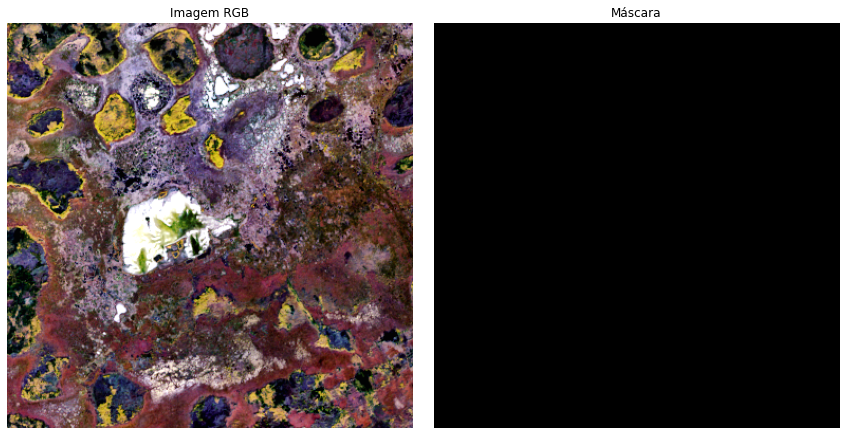

Entrada inválida. Por favor, responda com 's' para sim ou 'n' para não.
Entrada inválida. Por favor, responda com 's' para sim ou 'n' para não.
Entrada inválida. Por favor, responda com 's' para sim ou 'n' para não.
Entrada inválida. Por favor, responda com 's' para sim ou 'n' para não.
Arquivos mantidos.
Finalizando a visualização.
Finalizando a visualização.


In [3]:
while True:
    visualize_and_manage_images_masks()
    continuar = input("Deseja visualizar outra imagem? (s/n): ").strip().lower()
    if continuar != 's':
        print("Finalizando a visualização.")
        break

# Dados de teste

In [2]:
# Diretórios de entrada - Teste
test_red_dir = '../data/raw/38-Cloud_test/test_red'
test_green_dir = '../data/raw/38-Cloud_test/test_green'
test_blue_dir = '../data/raw/38-Cloud_test/test_blue'

# Diretórios de saída - Teste
output_test_dir = '../data/dados_teste/images'
os.makedirs(output_test_dir, exist_ok=True)

# Diretório para armazenar imagens excluídas
excluded_test_dir = '../data/dados_teste/excluidas'
os.makedirs(excluded_test_dir, exist_ok=True)

In [3]:
# Listar arquivos de teste
test_red_files = sorted(os.listdir(test_red_dir))
test_green_files = sorted(os.listdir(test_green_dir))
test_blue_files = sorted(os.listdir(test_blue_dir))

# Verificar se os arquivos correspondem
assert len(test_red_files) == len(test_green_files) == len(test_blue_files), "Número de arquivos de bandas incompatível"

In [ ]:
# Processar e salvar as imagens de teste
excluded_count = 0  # Contador de imagens excluídas

for r_file, g_file, b_file in tqdm(zip(test_red_files, test_green_files, test_blue_files), desc="Processando imagens de teste", total=len(test_red_files)):
    r_path = os.path.join(test_red_dir, r_file)
    g_path = os.path.join(test_green_dir, g_file)
    b_path = os.path.join(test_blue_dir, b_file)

    # Verificar imagens completamente pretas
    if is_band_all_zeros(r_path) and is_band_all_zeros(g_path) and is_band_all_zeros(b_path):
        # Mover os arquivos originais para o diretório de excluídos
        try:
            shutil.move(r_path, os.path.join(excluded_test_dir, r_file))
            shutil.move(g_path, os.path.join(excluded_test_dir, g_file))
            shutil.move(b_path, os.path.join(excluded_test_dir, b_file))
            excluded_count += 1
        except Exception as e:
            print(f"Erro ao mover arquivos {r_file}, {g_file}, {b_file}: {e}")
        continue  # Pular para a próxima iteração

    # Carregar e normalizar bandas
    red_band = load_and_normalize_band(r_path)
    green_band = load_and_normalize_band(g_path)
    blue_band = load_and_normalize_band(b_path)

    # Combinar em RGB
    rgb_image = combine_rgb(red_band, green_band, blue_band)

    # Gerar um ID único para nomear o arquivo
    unique_id = str(uuid.uuid4())

    # Salvar a imagem RGB
    img_output_path = os.path.join(output_test_dir, f"{unique_id}.png")
    Image.fromarray(rgb_image).save(img_output_path)

print(f"Imagens de teste processadas e salvas com sucesso. {excluded_count} imagens foram excluídas por terem bandas completamente pretas.")